# 06 - PyTorch transfer learning

## 0. Python transfer logic

What is transfer learning?
Transfer leaning involves taking the paramas of what one omdel has learned on another dataset and applying to the model

* Pretrained model = foundational net

In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.9.1+cu126
0.24.1+cu126


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] could not find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary
    
# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine


In [4]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get Data

Need pizze, steak, sushi data to build a transfer learning model on

In [5]:
import os
import zipfile
from pathlib import Path

import requests

# Setup data path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi" # images from a subset of classes from the Food101 dataset

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory already exists, skipping download.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)
        
    # unzip pizz, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)
        
    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

data\pizza_steak_sushi directory already exists, skipping download.


In [6]:
# Setup directory path
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders

Got some data, now turn it into PyTorch DataLoaders.

To do so, use `data_setup.py` and the `create_dataloaders()` function in `05_pytorch_going_modular.ipynb`

There's one thing we have to think about when loading: how to **transform** it? And with `torchvision` 0.13+ there's two ways to do this:

1. Manually created transforms - you define what transforms you want your data to go through
2. Automatically created transforms - the transforms for your data are defined by the mode you'd like to use.

Important point: when using a pretrained model, it's important that the data (including custom data) that you pass through it is **transformed** in the same way that the data the model was trained on.

In [7]:
from going_modular.going_modular import data_setup

### 2.1 Creating a transform for `torchvision.models` (manual creation)

`torchvision.models` contains pretrained models (models ready for transfer learning) right within `torchvision`.

> 
> All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].
> 

In [8]:
import torchvision

torchvision.__version__

'0.24.1+cu126'

In [9]:
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transform = transforms.Compose([
                                        transforms.Resize((224, 224)), # resize image to 224x224
                                        transforms.ToTensor(), # Get images into range [0, 1]
                                        normalize]) # Make sure iamges have the same distribution as ImageNet images

In [10]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
                                                                                train_dir=train_dir,
                                                                                test_dir=test_dir,
                                                                                transform=manual_transform,
                                                                                batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x21ce9e1af90>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transform for `torchvision.models` (auto creation)

As of `torchvision` v0.13+, there is now support for automatic data transform creation based on the pretrained model weights you're using.

In [11]:
import torchvision
torchvision.__version__

'0.24.1+cu126'

In [12]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # "DEFAULT" = best available / best performing weights
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [13]:
# Get the transforms used to create the pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [14]:
# Create DataLoaders using automatic transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
                                                                                train_dir=train_dir,
                                                                                test_dir=test_dir,
                                                                                transform=auto_transforms,
                                                                                batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x21ce9db3890>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

There are various places to get a pretrained model, such as:
1. PyTorch domain libraries
2. Libraries like `timm` (torch image models)
3. HuggingFace Hub (for plenty of different models)
4. Paperswithcode (for models across diferrent problem spaces/domains)

### 3.1 Which pretrained model should you use?

*Experiment*

The whole idea of transfer learning: take an already well-performing model from a problem space similar to your own and then customize to your own problem.

Three things to consider:
1. Speed - How fast does it run?
2. Size - How big is the model?
3. Performance - how well does it go on your chosen problem (e.g. how well does it classify food images? For FoodVision mini?)

Where does the model live?

Is it on device? (like a self-driving car)

Or does it live on a server?

Looking at https://docs.pytorch.org/vision/main/models.html#table-of-all-available-classification-weights

Which model should we choose?

For our case (deploying FoodVision Mini on a mobile device), it looks like EffNetB0 is one of the best options in terms performance vs size.

However, in light of The Bitter Lession - https://www.cs.utexas.edu/~eunsol/courses/data/bitter_lesson.pdf, if we had infinite compute, we'd likely pick the biggest model + most parameters + most general we could.

### 3.2 Setting up a pretrained model

Want to create an instance of a pretrained EffNetB0 - https://docs.pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b0.html#torchvision.models.EfficientNet_B0_Weights

In [15]:
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [16]:
# OLD method of creating a pretrained model (prior to torchvision v0.13+)
# model = torchvision.models.efficientnet_b0(pretrained=True)

# NEW method of creating a pretrained model (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # "DEFAULT" = best available / best performing weights
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [17]:
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [18]:
model.avgpool

AdaptiveAvgPool2d(output_size=1)

In [19]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

### 3.3 Getting a summary of the model with `torchinfo.summary()`

In [20]:
# Print with torchinfo
from torchinfo import summary

summary(
    model,
    input_size=(1, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)  # [batch_size, color_channels, height, width]

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### 3.4 Freezing the base model and changin the output layer to suit our needs

With a feature extractor model, typically you will "freeze" the base layers of a pretrained/foundation model and update the output layers to suit your own problem.

In [21]:
# Freeze all of the base layers in EffNetB0

for param in model.features.parameters():
    param.requires_grad = False # Turn off gradient tracking

In [22]:
# Update the classifier head of the model to suit our problem
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names))).to(device) # How many classes do we have

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [23]:
summary(
    model,
    input_size=(1, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)  # [batch_size, color_channels, height, width]

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 4. Train model

In [24]:
# Define the loss and opimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [25]:
# Import train function
from going_modular.going_modular import engine

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] total training time: {end_time-start_time:.3f} seconds")

 10%|█         | 1/10 [01:07<10:05, 67.24s/it]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9132 | test_acc: 0.5398


 20%|██        | 2/10 [02:22<09:33, 71.69s/it]

Epoch: 2 | train_loss: 0.8717 | train_acc: 0.7773 | test_loss: 0.7911 | test_acc: 0.8153


 30%|███       | 3/10 [03:36<08:31, 73.04s/it]

Epoch: 3 | train_loss: 0.7648 | train_acc: 0.7930 | test_loss: 0.7463 | test_acc: 0.8561


 40%|████      | 4/10 [04:52<07:25, 74.26s/it]

Epoch: 4 | train_loss: 0.7109 | train_acc: 0.7539 | test_loss: 0.6373 | test_acc: 0.8655


 50%|█████     | 5/10 [06:04<06:06, 73.32s/it]

Epoch: 5 | train_loss: 0.6255 | train_acc: 0.7852 | test_loss: 0.6260 | test_acc: 0.8561


 60%|██████    | 6/10 [07:13<04:47, 71.99s/it]

Epoch: 6 | train_loss: 0.5784 | train_acc: 0.8945 | test_loss: 0.5743 | test_acc: 0.8759


 70%|███████   | 7/10 [08:27<03:37, 72.37s/it]

Epoch: 7 | train_loss: 0.5263 | train_acc: 0.9102 | test_loss: 0.5469 | test_acc: 0.8759


 80%|████████  | 8/10 [09:41<02:25, 72.97s/it]

Epoch: 8 | train_loss: 0.5226 | train_acc: 0.8008 | test_loss: 0.5290 | test_acc: 0.8665


 90%|█████████ | 9/10 [10:47<01:10, 70.77s/it]

Epoch: 9 | train_loss: 0.5670 | train_acc: 0.8125 | test_loss: 0.5076 | test_acc: 0.8456


100%|██████████| 10/10 [11:55<00:00, 71.54s/it]

Epoch: 10 | train_loss: 0.4847 | train_acc: 0.8203 | test_loss: 0.4399 | test_acc: 0.9062
[INFO] total training time: 715.373 seconds


In [26]:
results

{'train_loss': [1.0923994481563568,
  0.8716587051749229,
  0.7647855803370476,
  0.7108565121889114,
  0.6254696249961853,
  0.5784141235053539,
  0.5262590795755386,
  0.522639088332653,
  0.5670051872730255,
  0.4847072921693325],
 'train_acc': [0.3984375,
  0.77734375,
  0.79296875,
  0.75390625,
  0.78515625,
  0.89453125,
  0.91015625,
  0.80078125,
  0.8125,
  0.8203125],
 'test_loss': [0.9132464528083801,
  0.7911483844121298,
  0.7462918957074484,
  0.6372959613800049,
  0.6260354320208231,
  0.57429438829422,
  0.5468953450520834,
  0.5290347536404928,
  0.5075912574927012,
  0.43990492820739746],
 'test_acc': [0.5397727272727273,
  0.8153409090909092,
  0.8560606060606061,
  0.8655303030303031,
  0.8560606060606061,
  0.8759469696969697,
  0.8759469696969697,
  0.8664772727272728,
  0.8456439393939394,
  0.90625]}

## 5. Evaluate model by plotting loss curves

In [27]:
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] could not find helper_functions.py... downloading it from GitHub.")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

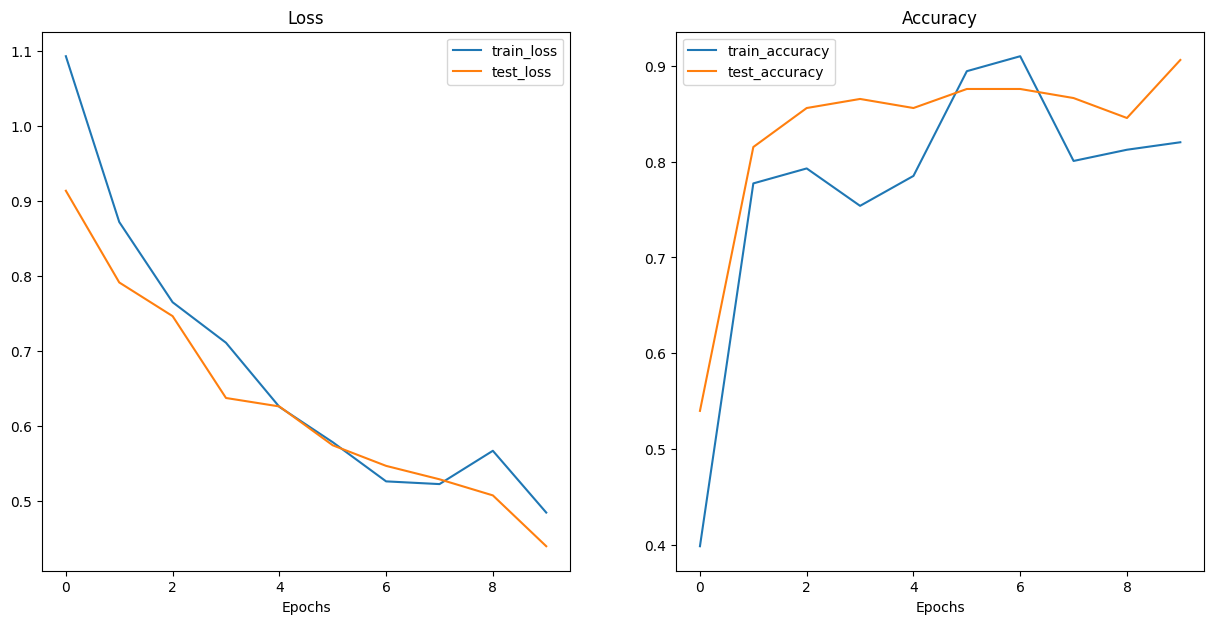

In [28]:
# Plot the loss curves of the model
plot_loss_curves(results)

## 6. Make predictions on images from the test set

Some things to keep in mid when making predictions/inference on test data/custom data.

We have to make sure that the test/custom data is:
* Same shape - images need to be same shape as model was trained on
* Same datatype - custom data should be in the same data type
* Same device - custom data/test data should be on the same device as the model
* Same transform - if you've transformed your custom data, ideally you will transform the test data and custom data the same

To do all of this automatically, let's create a function called `pred_and_plot_image()` in `11.3 Putting custom image prediction together: Building a function` from [`04_pytorch_custom_dataset.ipynb`](../04_pytorch_custom_datasets/04_pytorch_custom_datasets.ipynb)

1. Take in a trained model, a list of class names, a filepath to a target image, an image size, a transform and a tartget device
2. Open the image with `PIL.Image.Open()`
3. Create a transform if one doesn't exist
4. Make sure the model is on the target device
5. Turn the model to `model.eval()` mode to make sure it's ready for inference (this will turn off things like `nn.Dropout()`)
6. Transform the target image and make sure its dimentionality is suited for the model (this mainly relates to batch size)
7. Make a prediction on the image by passing to the model
8. Convert the model's output logits to prediction probabilities using `torch.softmax()`
9. Convert model's prediction probabilities to prediction labels using `torch.argmax()`
10. Plot the image with `matplotlib` and set the title to the prediction label from step 9 and prediction probabilities from step 8

In [40]:
from typing import List, Tuple

from PIL import Image

from torchvision import transforms

# 1. Take in trained model
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str]=None,
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device:torch.device = device):
    
    # 2. Open the image with PIL
    img = Image.open(image_path).convert("RGB")
    
    # 3. Create a transform if one doens't exist
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])
    
    ### Predict on images
    # 4. Make sure the model is on the target device
    model.to(device)
    
    
    # 5. Turn on inference mode and eval mode
    model.eval()
    with torch.inference_mode():
        # 6. Transform the image and add an extra batch dimension
        transformed_image = image_transform(img).unsqueeze(dim=0) # [batch_Size, color_channels, height, width]
        
        # 7. Make a prediction on the transformed image by passing it to the model (also ensure it's on the target device)
        target_image_pred = model(transformed_image.to(device))
        
    # 8. Convert the model outputs into prediction probabilities and labels
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1) # dim=1 -> along the classes
    # print(target_image_pred_probs.max())
    
    # 9. Convert the prediction probabilities into prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    
    # 10. Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

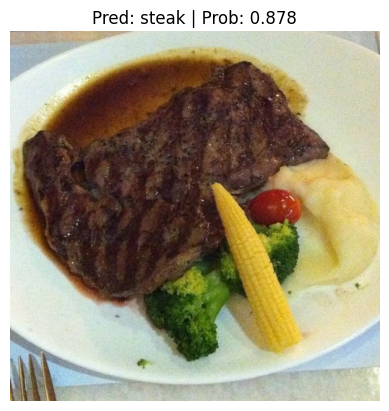

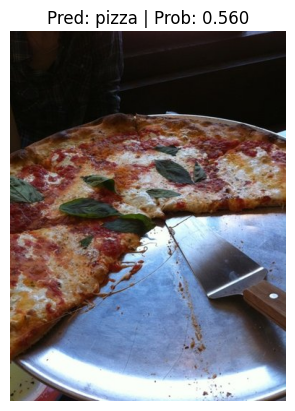

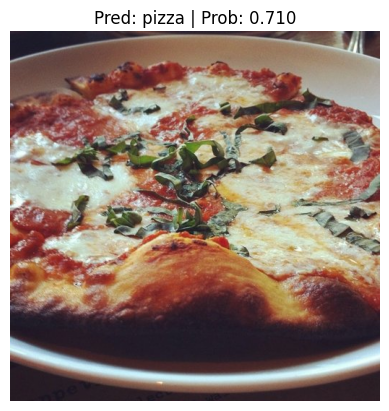

In [41]:
# Get a random list of image paths from the test dataset
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(test_image_path_list, k=num_images_to_plot)
test_image_path_sample

# Make predictions on and ploy the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=class_names,
                        transform=auto_transforms,
                        device=device)

### 6.1 Making a predictions on a custom image

Let's make a prediction on a random pizza image

In [45]:
# Setup custom image path
custom_image_path = data_path / "steak-pic.jpg"

if custom_image_path.is_file():
    print(f"{custom_image_path} already exists, skipping download.")

data\steak-pic.jpg already exists, skipping download.


In [46]:
class_names

['pizza', 'steak', 'sushi']

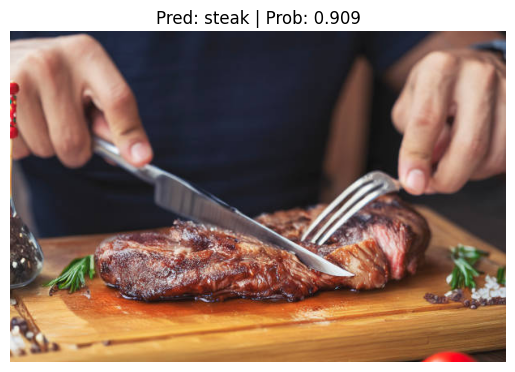

In [47]:
# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=auto_transforms,
                    device=device)